In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()


In [4]:
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

In [5]:
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = cv_scores.mean()
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Logistic Regression: 0.5075 (+/- 0.0242)
Decision Tree: 0.4487 (+/- 0.0183)
Random Forest: 0.4725 (+/- 0.0122)
Gradient Boosting: 0.4825 (+/- 0.0155)
SVM: 0.5062 (+/- 0.0209)
KNN: 0.4662 (+/- 0.0229)


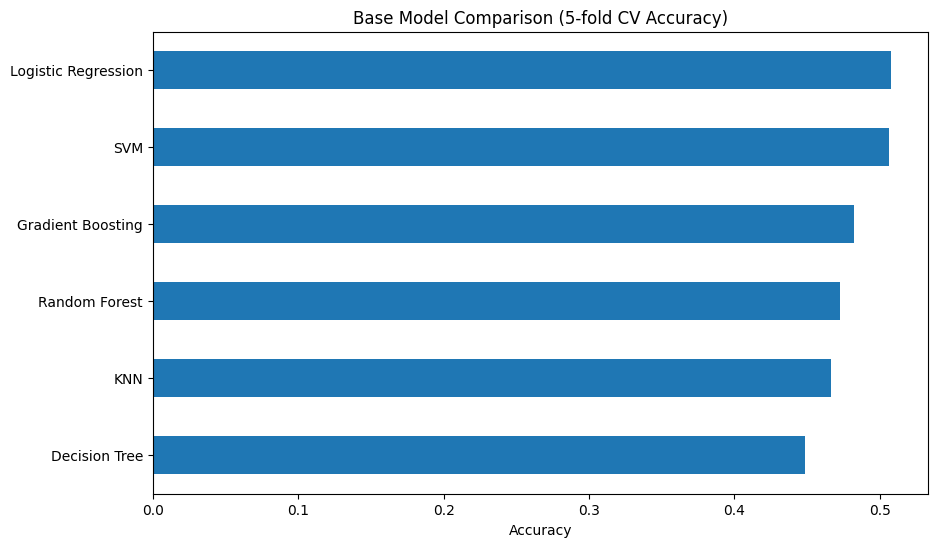

In [6]:
plt.figure(figsize=(10, 6))
pd.Series(results).sort_values().plot(kind='barh')
plt.title('Base Model Comparison (5-fold CV Accuracy)')
plt.xlabel('Accuracy')
plt.show()

In [9]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



In [10]:
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                      param_grid=rf_params,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_


In [11]:
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5]
}


In [12]:
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42),
                      param_grid=gb_params,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

In [13]:
final_models = {
    'Random Forest (tuned)': best_rf,
    'Gradient Boosting (tuned)': best_gb
}


Random Forest (tuned) Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.39      0.33      0.35        52
           2       0.47      0.61      0.53       103
           3       0.10      0.05      0.07        39

    accuracy                           0.41       200
   macro avg       0.24      0.25      0.24       200
weighted avg       0.36      0.41      0.38       200



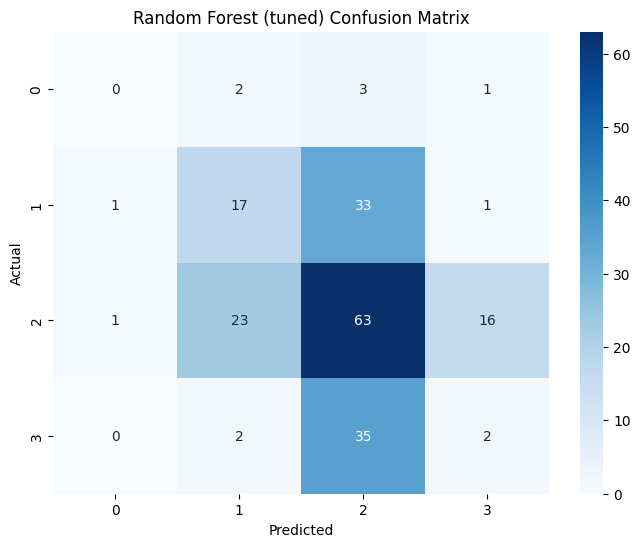


Gradient Boosting (tuned) Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.53      0.31      0.39        52
           2       0.52      0.83      0.64       103
           3       0.29      0.05      0.09        39

    accuracy                           0.52       200
   macro avg       0.34      0.30      0.28       200
weighted avg       0.46      0.52      0.45       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


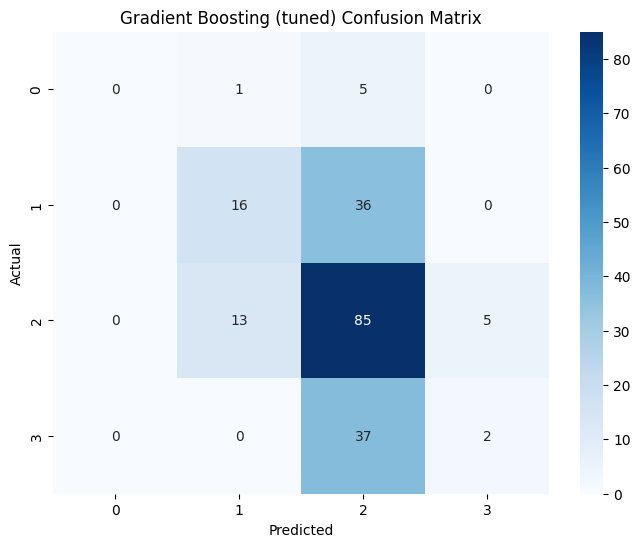

In [19]:
for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

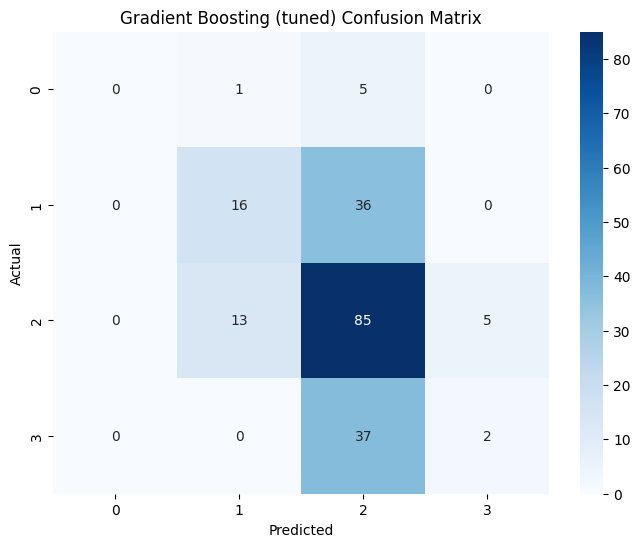

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # <- This line should be flush left (no extra indentation)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{name} Confusion Matrix')  # Fixed f-string (added missing variable)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

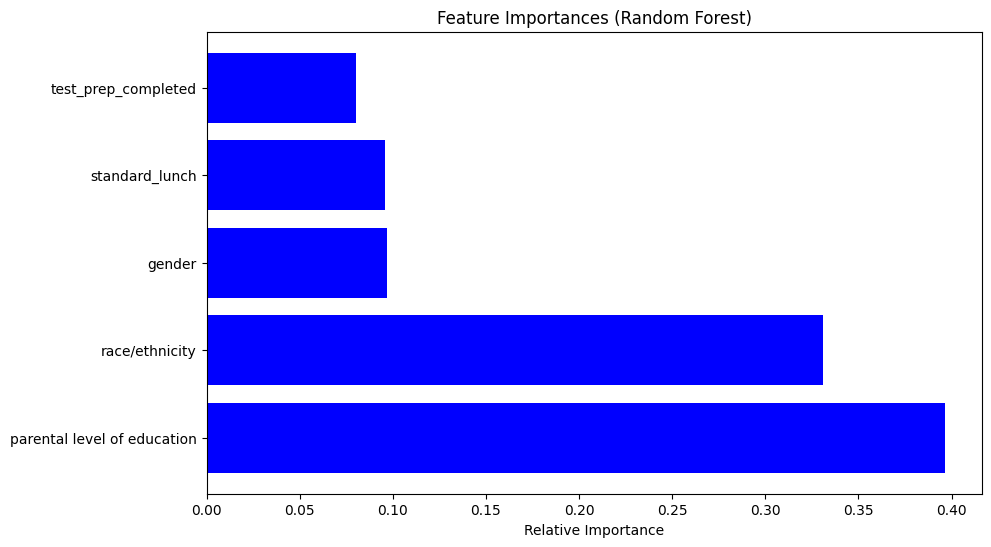

In [21]:
plt.figure(figsize=(10, 6))
importances = best_rf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [23]:
joblib.dump(best_rf, 'best_model.pkl')

['best_model.pkl']